In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn as sns
import datetime as dt
import boto3, yaml
from datetime import timedelta

from sklearn.model_selection import TimeSeriesSplit,train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler, label_binarize, MinMaxScaler
from imblearn.over_sampling import SMOTE
import sys,os

from joblib import dump, load

util_path = os.path.abspath(os.path.join(os.path.pardir, '../sasse-polygon-process/lib'))
if util_path not in sys.path and os.path.exists(util_path):
    sys.path.insert(0, util_path)
    
from config import read_options
from util import plot_class_hist 

sns.set()
sns.set_style("whitegrid")
%matplotlib inline

# Initialize

In [42]:
class Options(): pass

options = Options()
options.config_filename = '../cnf/rfc.ini'
options.config_name = 'forest'
read_options(options)

options_thin = Options()
options_thin.config_filename = '../cnf/rfc.ini'
options_thin.config_name = 'thin'
read_options(options_thin)

In [43]:
def save_model(model, fname, remote_name):
    """ Save model and upload it to bucket """
    
    save_path = os.path.dirname(os.path.abspath(fname))

    if not os.path.exists(save_path):
        os.mkdir(save_path)
    
    dump(model, fname)
    
    s3 = boto3.resource('s3')
    s3.meta.client.upload_file(fname, 'fmi-asi-sasse-assets', remote_name)

In [44]:
def classify(dataset, limits=None, based_on='outages'):
    # outages
    if limits is None:
        limits = [(0,0), (1,5), (5, 9999999)]
        
    i = 0
    for low, high in limits:
        dataset.loc[(dataset.loc[:, based_on] >= low) & (dataset.loc[:, based_on] <= high), 'class'] = i
        i += 1
        
    return dataset

In [45]:
def get_data(file_, options, name, scaler=None, verbose=False, limits=None, shuffle=True, test_size=.25, time_range=None):
    """ Read and normalise data """
        
    data = pd.read_csv(file_)
    
    data = data.loc[(data['weather_parameter'] == 'WindGust') & (data['low_limit'] == 15)].fillna(0)
    
    # Forest data gathering process have been ran twice for some cases. We have duplicate rows in the data.
    data.drop_duplicates(subset='id', inplace=True)
        
    label = options.label[0]
    
    data['point_in_time'] = pd.to_datetime(data['point_in_time'])        
    data['week'] = data['point_in_time'].dt.week

    missing = list(set(options.feature_params + options.meta_params + options.label)-set(data.columns.values))
    if len(missing) > 0:
        raise ValueError("Missing parameter(s) {}".format(','.join(missing)))
    
    if limits is not None:
        data = classify(data, limits)
    
    if shuffle:
        y = data.loc[:, options.label].values.ravel()
        data_train, data_test, _, __ = train_test_split(data, y, stratify=y, shuffle=shuffle, test_size=test_size, train_size=1-test_size)
    else:
        data.sort_values(by='point_in_time', inplace=True)
        # With time range
        if time_range is not None:
            # Prepare
            data.loc[:,'point_in_time'] = pd.to_datetime(data['point_in_time'])
            data.set_index('point_in_time', drop=True, inplace=True)
            data.index = data.index.tz_convert(tz='Europe/Helsinki')
            # Keep time during merge
            data.loc[:,'t'] = data.index
            # Select test range
            data_test = data[time_range[0]:time_range[1]]
            # Select rest to train 
            df_all = data.merge(data_test.drop_duplicates(), how='left', indicator=True)
            data_train = df_all[(df_all['_merge'] == 'left_only')]
            # Reset point in time
            data_train.loc[:, 'point_in_time'] = data_train['t']
            data_test.loc[:,'point_in_time'] = data_test['t']
        else:
        # With timeseries split
            splits = list(TimeSeriesSplit(n_splits=int(1/test_size)).split(data))
            data_train, data_test = data.iloc[splits[-1][0],:], data.iloc[splits[-1][1],:]
    
    # For analysis
    if verbose:
        for c in [1,2,3]:
            print('Dates in testset class {}:'.format(c))
            for i, row in data_test[(data_test['class']==c)].iterrows():
                print(row.point_in_time, end=',')
            print("\n")    
    
    X_train = data_train.loc[:, options.feature_params]
    y_train = data_train.loc[:, options.label]
    meta_train = data_train.loc[:, options.meta_params]

    X_test = data_test.loc[:, options.feature_params]
    y_test = data_test.loc[:, options.label]
    meta_test = data_test.loc[:, options.meta_params]
    
    # Scale
    if scaler is None:
        scaler = StandardScaler()      
    
    try:
        X_train = pd.DataFrame(scaler.transform(X_train), columns=options.feature_params)
    except:
        local_name = '../data/models/scaler/{}.joblib'.format(name)
        remote_name = 'models/scaler/{}.joblib'.format(name)
        X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=options.feature_params)
        save_model(scaler, local_name, remote_name)
        print('Saved scaler scaler {} and uploaded it to {}'.format(local_name, remote_name))

    X_test = pd.DataFrame(scaler.transform(X_test), columns=options.feature_params)
            
    sm = SMOTE()
    X_res, y_res = sm.fit_resample(X_train, y_train)
    
    train = pd.concat([X_train.reset_index(drop=True), y_train.reset_index(drop=True), meta_train.reset_index(drop=True)], axis=1)
    test = pd.concat([X_test.reset_index(drop=True), y_test.reset_index(drop=True), meta_test.reset_index(drop=True)], axis=1)
    res = pd.concat([pd.DataFrame(X_res, columns=options.feature_params), pd.DataFrame(y_res, columns=options.label)], axis=1)
    
    return train, test, res, scaler

In [46]:
def cut_classes(dataset, classes, max_size, label): 
    """ Decrease dataset size by cutting requested classes smaller """
    
    # Cherry picked classes
    class_dfs = []
    for c in classes: 
        picked_data = dataset.loc[(dataset.loc[:,label] == c),:].reset_index(drop=True)
        class_dfs.append(picked_data.loc[0:min(len(picked_data), max_size),:])
        #class_dfs.append(picked_data.sample(n=min(len(picked_data), max_size)))

    # Concat
    data = pd.concat(class_dfs)
    return data

In [47]:
def save_dataset(datasets):
    """ Save data to local filesystem and S3 """
    
    for name, data in datasets:
        filename = '../data/{}.csv'.format(name)
        remote_name = 'data/{}.csv'.format(name)

        data.to_csv(filename, index=False)
        
        s3 = boto3.resource('s3')
        s3.meta.client.upload_file(filename, 'fmi-asi-sasse-assets', remote_name)

# Loiste - JSE 2010-2012

1. Read whole dataset
1. Re-classify it to three classes. Limit 1-3 for class 1 is selected so that class 1 contain 80 % of all cases with at least 1 outage.
1. Split to train (70 %) and test set (70 %) (randomly)
1. Create smaller training set by limiting class sizes to maximum limit (smaller classes are not affected). Testset remain the same.

In [62]:
# Ensure that 1-3 outages cover 80 % of all outages cases
data = pd.read_csv('../data/classification_dataset_loiste_jse_forest.csv')
print(len(data[(data['outages'] > 0) & (data['outages'] < 3)])/len(data[(data['outages'] > 0)]))
print(len(data[(data['outages'] == 0)])/len(data))
print(len(data[(data['outages'] > 0) & (data['outages'] < 140)])/len(data))

0.7926364790520525
0.9037160785592047
0.09628392144079537


In [49]:
#print('All params:')
name = 'loiste_jse_recent'
limits = [(0,0), (1,3), (3, 9999999)]
test_size=.1
shuffle=False
time_range=('2017-01-01', '2018-12-31')
train_all_loiste, test_all_loiste, res_all_loiste, scaler_loiste_jse_all = get_data('../data/classification_dataset_loiste_jse_forest.csv', 
                                                                                    options, 
                                                                                    '{}_all'.format(name), 
                                                                                    verbose=False, 
                                                                                    limits=limits,
                                                                                    shuffle=shuffle,
                                                                                    test_size=test_size,
                                                                                    time_range=time_range)

#print("\n")
#print('Thin setup:')
train_thin_loiste, test_thin_loiste, res_thin_loiste, scaler_loiste_jse_thin = get_data('../data/classification_dataset_loiste_jse_forest.csv', 
                                                                                        options_thin, 
                                                                                        '{}_thin'.format(name), 
                                                                                        verbose=False, 
                                                                                        limits=limits,
                                                                                        shuffle=shuffle,
                                                                                        test_size=test_size,
                                                                                        time_range=time_range)

train_small_loiste = cut_classes(train_all_loiste, [0,1,2], 1000, options.label[0]) 
train_thin_small_loiste = cut_classes(train_thin_loiste, [0,1,2], 1000, options.label[0]) 

train_tiny_loiste = cut_classes(train_all_loiste, [0,1,2], 500, options.label[0]) 
train_thin_tiny_loiste = cut_classes(train_thin_loiste, [0,1,2], 500, options.label[0]) 

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Saved scaler scaler ../data/models/scaler/loiste_jse_recent_all.joblib and uploaded it to models/scaler/loiste_jse_recent_all.joblib
Saved scaler scaler ../data/models/scaler/loiste_jse_recent_thin.joblib and uploaded it to models/scaler/loiste_jse_recent_thin.joblib


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [50]:
dfdup = pd.concat([train_all_loiste, test_all_loiste])
assert len(dfdup[(dfdup.duplicated())]) == 0
dfdup = pd.concat([train_small_loiste, test_all_loiste])
assert len(dfdup[(dfdup.duplicated())]) == 0
dfdup = pd.concat([train_thin_loiste, test_thin_loiste])
assert len(dfdup[(dfdup.duplicated())]) == 0

In [51]:
test_thin_loiste.sort_values(by='point_in_time')

,speed_self,angle_self,area_m2,area_diff,MIN Temperature,AVG Temperature,MAX Temperature,MIN Dewpoint,AVG Dewpoint,MAX Dewpoint,...,id,storm_id,weather_parameter,high_limit,outages,customers,transformers,all_customers,class_customers,point_in_time
0,-2.142979,0.827005,0.957372,3.612517,-3.547642,-1.553827,-0.907543,-3.717808,-1.415861,-0.861667,...,730833,730833-WindGust-15-999,WindGust,999,0,0,1,4,0,2017-01-07 02:00:00+02:00
1,0.644397,0.379155,1.151756,0.293908,-3.547642,-1.421242,-0.153733,-3.847665,-1.415861,0.326897,...,730959,730833-WindGust-15-999,WindGust,999,0,0,77,803,0,2017-01-07 03:00:00+02:00
2,-2.142979,0.217594,2.243520,6.822323,-3.547642,-1.023487,-0.279368,-3.717808,-0.964885,-0.267385,...,731093,731109-WindGust-20-999,WindGust,999,0,0,44,287,0,2017-01-07 04:00:00+02:00
3,0.337636,0.718280,-0.566383,-0.190296,-1.514014,-2.084167,-2.289529,-1.380389,-2.017162,-2.347373,...,731102,729561-WindGust-15-999,WindGust,999,0,0,18,110,0,2017-01-07 04:00:00+02:00
4,0.351841,0.577367,2.269301,-0.126870,-3.428017,-0.890902,-0.279368,-3.587952,-0.964885,-0.118814,...,731204,731226-WindGust-25-999,WindGust,999,0,0,262,3769,0,2017-01-07 05:00:00+02:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1230,0.527243,0.735697,-0.565837,-0.189381,-0.078511,-0.493147,-0.781908,0.048033,-0.213259,-0.564526,...,918337,918140-WindGust-15-999,WindGust,999,0,0,71,793,0,2018-10-30 20:00:00+02:00
1231,-2.142979,-0.127846,-0.566721,-0.191121,-0.557012,-1.023487,-1.284448,-0.860963,-1.415861,-1.753090,...,918347,918347-WindGust-15-999,WindGust,999,0,0,4,13,0,2018-10-30 20:00:00+02:00
1232,0.731904,0.112396,-0.503541,-0.035743,-0.437387,-0.625732,-0.656273,-0.601250,-0.664234,-0.415955,...,918364,918140-WindGust-15-999,WindGust,999,0,0,421,3826,0,2018-10-30 21:00:00+02:00
1233,0.446840,-0.150713,-0.528723,-0.254057,-0.437387,-0.758317,-0.781908,-0.601250,-0.664234,-0.713096,...,918415,918140-WindGust-15-999,WindGust,999,0,0,477,4183,0,2018-10-30 22:00:00+02:00


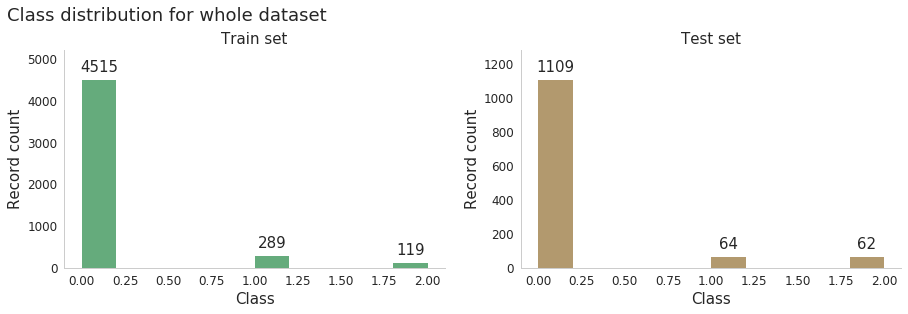

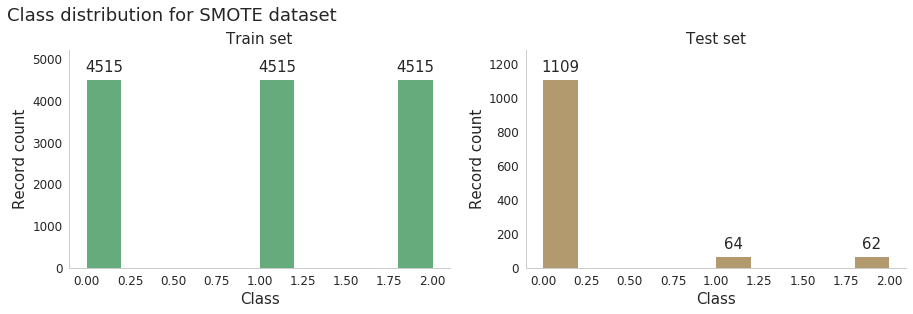

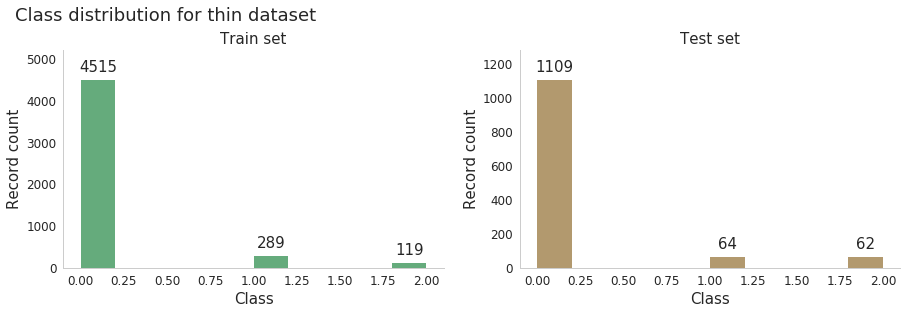

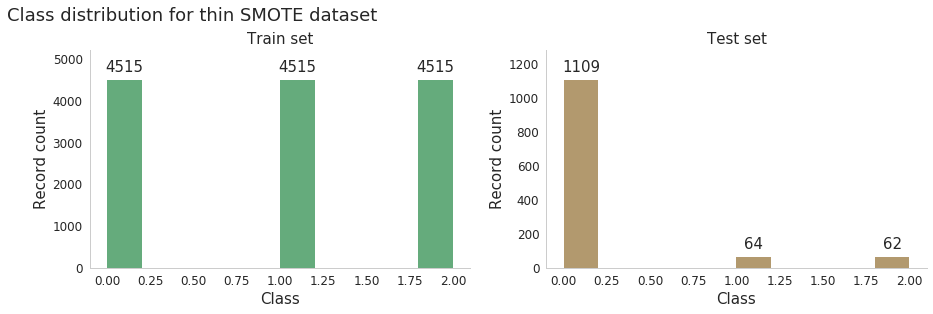

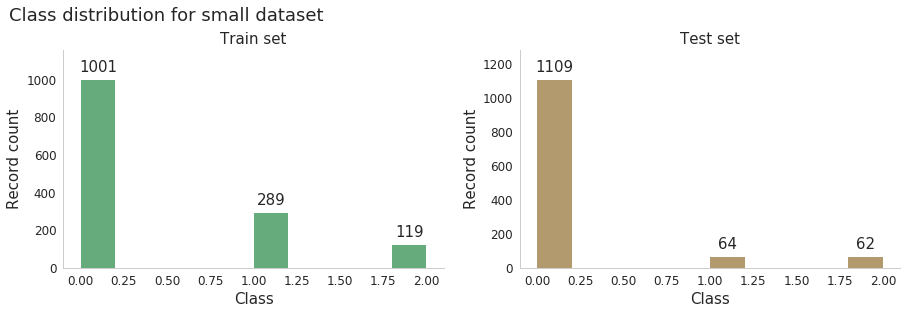

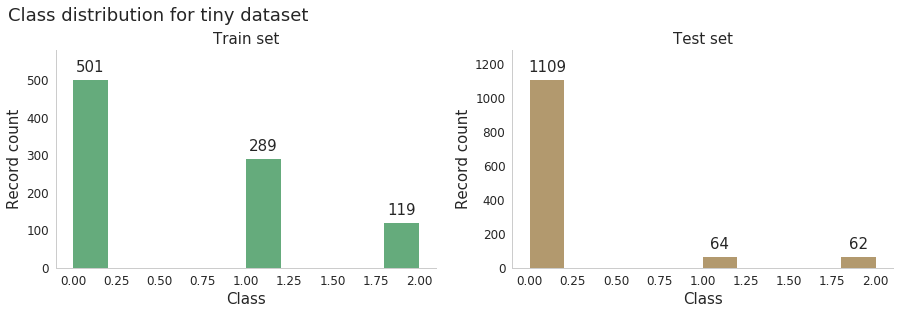

In [52]:
plot_class_hist(train_all_loiste, test_all_loiste, title='Class distribution for whole dataset', fontsize=15)
plot_class_hist(res_all_loiste, test_all_loiste, title='Class distribution for SMOTE dataset', fontsize=15)

plot_class_hist(train_thin_loiste, test_thin_loiste, title='Class distribution for thin dataset', fontsize=15)
plot_class_hist(res_thin_loiste, test_thin_loiste, title='Class distribution for thin SMOTE dataset', fontsize=15)

plot_class_hist(train_small_loiste, test_all_loiste, title='Class distribution for small dataset', fontsize=15)
plot_class_hist(train_tiny_loiste, test_all_loiste, title='Class distribution for tiny dataset', fontsize=15)

In [53]:
datasets = [('{}_all_train'.format(name), train_all_loiste), 
            ('{}_all_test'.format(name), test_all_loiste), 
            ('{}_res_train'.format(name), res_all_loiste),
            ('{}_thin_train'.format(name), train_thin_loiste),
            ('{}_thin_test'.format(name), test_thin_loiste),
            ('{}_thin_res_train'.format(name), res_thin_loiste),
            ('{}_small_train'.format(name), train_small_loiste),
            ('{}_small_thin_train'.format(name), train_thin_small_loiste),
            ('{}_tiny_train'.format(name), train_tiny_loiste),
            ('{}_tiny_thin_train'.format(name), train_thin_tiny_loiste)
           ]
save_dataset(datasets)

# Loiste - JSE Random

1. Read whole dataset
1. Re-classify it to three classes. Limit 1-3 for class 1 is selected so that class 1 contain 80 % of all cases with at least 1 outage.
1. Split to train (70 %) and test set (70 %) (randomly)
1. Create smaller training set by limiting class sizes to maximum limit (smaller classes are not affected). Testset remain the same.

In [54]:
# Ensure that 1-3 outages cover 80 % of all outages cases
data = pd.read_csv('../data/classification_dataset_loiste_jse_forest.csv')
print(len(data[(data['outages'] > 0) & (data['outages'] < 3)])/len(data[(data['outages'] > 0)]))

0.7926364790520525


In [55]:
#print('All params:')
name = 'loiste_jse_random'
limits = [(0,0), (1,3), (3, 9999999)]
test_size=.2
shuffle=True

train_all_loiste, test_all_loiste, res_all_loiste, scaler_loiste_jse_all = get_data('../data/classification_dataset_loiste_jse_forest.csv', 
                                                                                    options, 
                                                                                    '{}_all'.format(name), 
                                                                                    verbose=False, 
                                                                                    limits=limits,
                                                                                    shuffle=shuffle,
                                                                                    test_size=test_size)

#print("\n")
#print('Thin setup:')
train_thin_loiste, test_thin_loiste, res_thin_loiste, scaler_loiste_jse_thin = get_data('../data/classification_dataset_loiste_jse_forest.csv', 
                                                                                        options_thin, 
                                                                                        '{}_thin'.format(name), 
                                                                                        verbose=False, 
                                                                                        limits=limits,
                                                                                        shuffle=shuffle,
                                                                                        test_size=test_size)

train_small_loiste = cut_classes(train_all_loiste, [0,1,2], 1000, options.label[0]) 
train_thin_small_loiste = cut_classes(train_thin_loiste, [0,1,2], 1000, options.label[0]) 

train_tiny_loiste = cut_classes(train_all_loiste, [0,1,2], 500, options.label[0]) 
train_thin_tiny_loiste = cut_classes(train_thin_loiste, [0,1,2], 500, options.label[0]) 

Saved scaler scaler ../data/models/scaler/loiste_jse_random_all.joblib and uploaded it to models/scaler/loiste_jse_random_all.joblib
Saved scaler scaler ../data/models/scaler/loiste_jse_random_thin.joblib and uploaded it to models/scaler/loiste_jse_random_thin.joblib


In [56]:
dfdup = pd.concat([train_all_loiste, test_all_loiste])
assert len(dfdup[(dfdup.duplicated())]) == 0
dfdup = pd.concat([train_small_loiste, test_all_loiste])
assert len(dfdup[(dfdup.duplicated())]) == 0
dfdup = pd.concat([train_thin_loiste, test_thin_loiste])
assert len(dfdup[(dfdup.duplicated())]) == 0

In [57]:
test_thin_loiste.sort_values(by='point_in_time')

,speed_self,angle_self,area_m2,area_diff,MIN Temperature,AVG Temperature,MAX Temperature,MIN Dewpoint,AVG Dewpoint,MAX Dewpoint,...,id,storm_id,weather_parameter,high_limit,outages,customers,transformers,all_customers,class_customers,point_in_time
335,-2.154022,0.502056,-0.507429,0.011761,-0.435353,-0.651570,-0.567413,-0.986902,-0.849923,-0.608095,...,3736,3736-WindGust-15-999,WindGust,999,0,0,566,5033,0,2010-03-08 14:00:00+00:00
743,0.441360,0.773675,-0.574502,-0.205110,-0.317766,-0.518913,-0.691705,-0.084144,-0.395158,-0.756510,...,4996,4961-WindGust-15-999,WindGust,999,0,0,444,5744,0,2010-03-10 07:00:00+00:00
1130,0.507190,0.789194,-0.584825,-0.220327,-0.200179,-0.518913,-0.815997,0.044821,-0.395158,-0.756510,...,5045,4961-WindGust-15-999,WindGust,999,0,0,355,4185,0,2010-03-10 08:00:00+00:00
751,-2.154022,0.652797,-0.567844,-0.143833,-1.023288,-1.447511,-1.686040,-0.857936,-1.456276,-1.647004,...,17536,17536-WindGust-15-999,WindGust,999,0,0,17,101,0,2010-03-23 06:00:00+00:00
27,0.758892,0.223492,-0.574767,-1.002315,-0.788114,-1.314854,-1.437456,-0.986902,-1.607865,-1.795420,...,17661,17538-WindGust-15-999,WindGust,999,0,0,131,387,0,2010-03-23 08:00:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1161,0.449287,-0.234401,-0.192358,-0.337001,-0.317766,0.409685,0.799798,0.044821,0.817549,1.321309,...,889873,889634-WindGust-20-999,WindGust,999,0,0,452,3518,0,2018-10-05 12:00:00+00:00
1211,0.464730,0.487634,-0.584647,-0.187421,0.622929,0.277028,-0.070245,0.689648,0.362784,-0.014432,...,895984,895956-WindGust-15-999,WindGust,999,0,0,270,1421,0,2018-10-10 09:00:00+00:00
786,0.422392,0.824633,0.230338,-0.197119,0.387755,0.542342,0.551214,0.431717,1.120726,1.024478,...,908887,907909-WindGust-15-999,WindGust,999,0,0,8130,102577,0,2018-10-22 02:00:00+00:00
956,0.437241,-0.251346,0.143112,-0.353680,0.270168,0.542342,0.551214,0.431717,0.969138,1.172894,...,909008,907909-WindGust-15-999,WindGust,999,0,0,7186,89587,0,2018-10-22 04:00:00+00:00


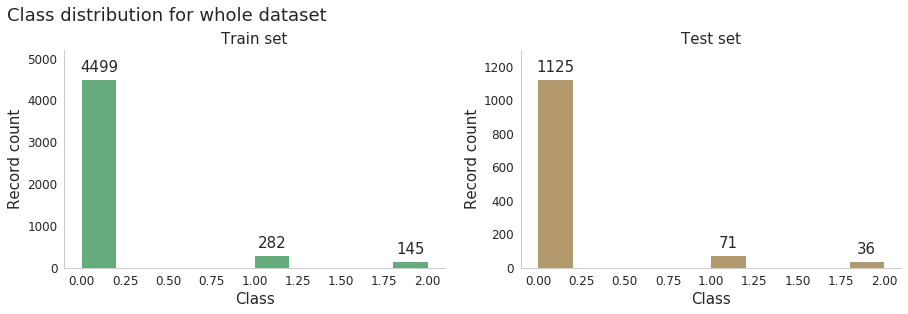

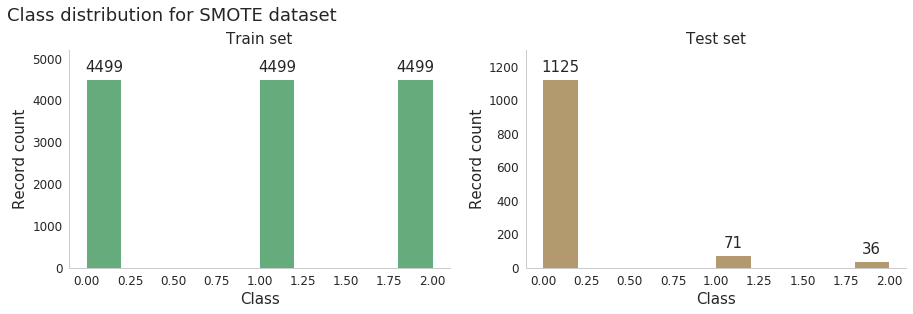

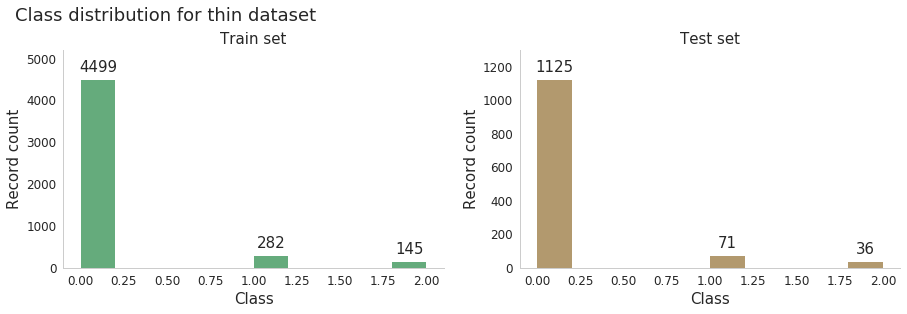

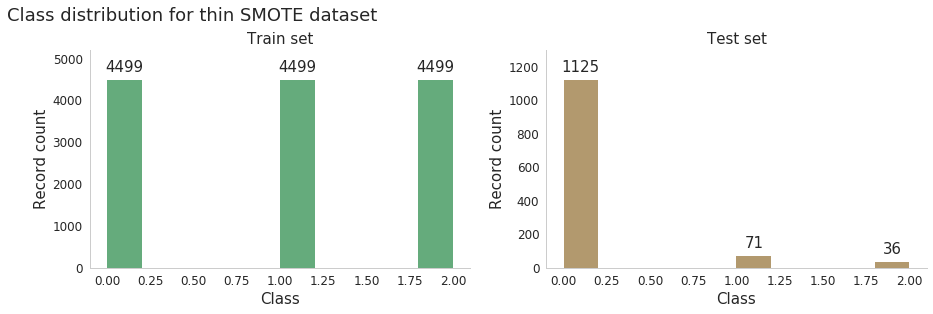

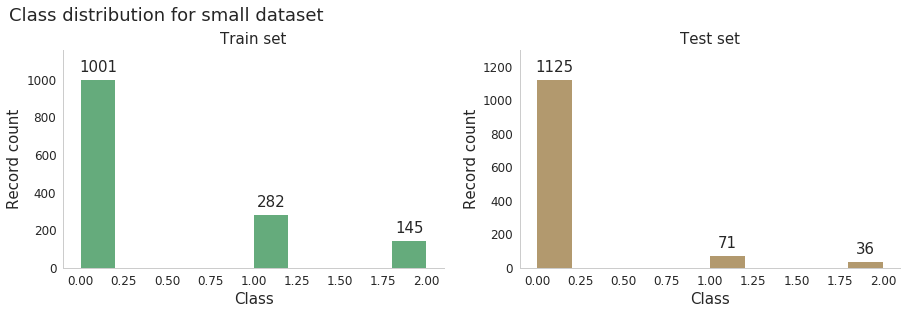

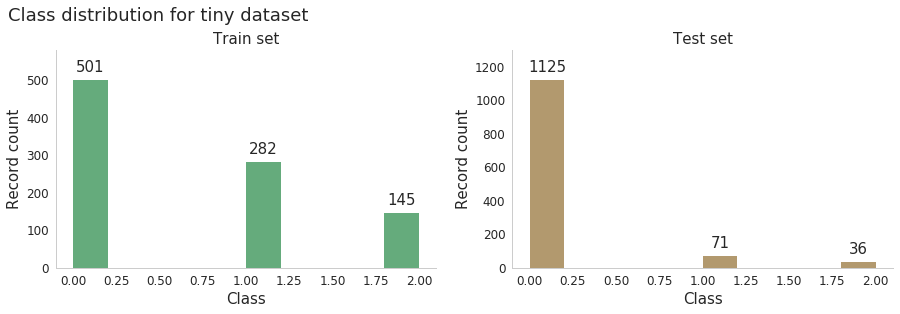

In [58]:
plot_class_hist(train_all_loiste, test_all_loiste, title='Class distribution for whole dataset', fontsize=15)
plot_class_hist(res_all_loiste, test_all_loiste, title='Class distribution for SMOTE dataset', fontsize=15)

plot_class_hist(train_thin_loiste, test_thin_loiste, title='Class distribution for thin dataset', fontsize=15)
plot_class_hist(res_thin_loiste, test_thin_loiste, title='Class distribution for thin SMOTE dataset', fontsize=15)

plot_class_hist(train_small_loiste, test_all_loiste, title='Class distribution for small dataset', fontsize=15)
plot_class_hist(train_tiny_loiste, test_all_loiste, title='Class distribution for tiny dataset', fontsize=15)

In [59]:
datasets = [('{}_all_train'.format(name), train_all_loiste), 
            ('{}_all_test'.format(name), test_all_loiste), 
            ('{}_res_train'.format(name), res_all_loiste),
            ('{}_thin_train'.format(name), train_thin_loiste),
            ('{}_thin_test'.format(name), test_thin_loiste),
            ('{}_thin_res_train'.format(name), res_thin_loiste),
            ('{}_small_train'.format(name), train_small_loiste),
            ('{}_small_thin_train'.format(name), train_thin_small_loiste),
            ('{}_tiny_train'.format(name), train_tiny_loiste),
            ('{}_tiny_thin_train'.format(name), train_thin_tiny_loiste)
           ]
save_dataset(datasets)

# Energiateollisuus

See above for explanation

In [19]:
class Options(): pass

options_ene = Options()
options_ene.config_filename = '../cnf/rfc.ini'
options_ene.config_name = 'forest_energiateollisuus'
read_options(options_ene)

options_ene_thin = Options()
options_ene_thin.config_filename = '../cnf/rfc.ini'
options_ene_thin.config_name = 'thin_energiateollisuus'
read_options(options_ene_thin)

In [61]:
data = pd.read_csv('../data/classification_dataset_energiateollisuus_forest.csv')
print(len(data[(data['outages'] > 0) & (data['outages'] < 140)])/len(data[(data['outages'] > 0)]))
print(len(data[(data['outages'] == 0)])/len(data))
print(len(data[(data['outages'] > 0) & (data['outages'] < 140)])/len(data))

0.8068877777449037
0.7634332589082612
0.19088281200786714


In [21]:
limits = [(0,0), (1,140), (140, 9999999)]
print('All params:')
train_all_energiateollisuus, test_all_energiateollisuus, res_all_energiateollisuus, scaler_energiateollisuus_all = get_data('../data/classification_dataset_energiateollisuus_forest.csv', options_ene, 'scaler_energiateollisuus_all', verbose=True, limits=limits)

print("\n")
print('Thin setup:')
train_thin_energiateollisuus, test_thin_energiateollisuus, res_thin_energiateollisuus, scaler_energiateollisuus_thin = get_data('../data/classification_dataset_energiateollisuus_forest.csv', options_ene_thin, 'scaler_energiateollisuus_thin', verbose=True, limits=limits)

train_small_energiateollisuus = cut_classes(train_all_energiateollisuus, [0,1,2,3], 1000, options_ene.label[0]) 
train_thin_small_energiateollisuus = cut_classes(train_thin_energiateollisuus, [0,1,2,3], 1000, options_ene_thin.label[0]) 

train_tiny_energiateollisuus = cut_classes(train_all_energiateollisuus, [0,1,2,3], 500, options_ene.label[0]) 
train_thin_tiny_energiateollisuus = cut_classes(train_thin_energiateollisuus, [0,1,2,3], 500, options_ene_thin.label[0]) 

All params:
Dates in testset class 1:
2012-12-13 21:00:00+00:00,2016-09-28 13:00:00+00:00,2013-08-14 10:00:00+00:00,2018-07-28 15:00:00+00:00,2016-12-30 10:00:00+00:00,2014-05-28 13:00:00+00:00,2018-08-23 06:00:00+00:00,2016-11-26 06:00:00+00:00,2015-12-21 04:00:00+00:00,2013-10-23 12:00:00+00:00,2018-08-19 06:00:00+00:00,2013-12-20 05:00:00+00:00,2018-01-06 17:00:00+00:00,2013-03-02 20:00:00+00:00,2015-02-16 12:00:00+00:00,2017-08-14 02:00:00+00:00,2012-09-20 11:00:00+00:00,2012-09-17 18:00:00+00:00,2013-12-05 08:00:00+00:00,2018-09-24 14:00:00+00:00,2017-04-21 07:00:00+00:00,2012-07-09 12:00:00+00:00,2017-12-12 20:00:00+00:00,2013-04-15 04:00:00+00:00,2010-08-22 06:00:00+00:00,2016-02-21 05:00:00+00:00,2013-08-17 15:00:00+00:00,2011-06-21 15:00:00+00:00,2015-11-14 02:00:00+00:00,2014-08-13 14:00:00+00:00,2015-11-28 21:00:00+00:00,2017-12-24 02:00:00+00:00,2012-10-30 08:00:00+00:00,2014-10-28 07:00:00+00:00,2012-09-17 06:00:00+00:00,2010-04-17 13:00:00+00:00,2011-11-14 16:00:00+00:00,

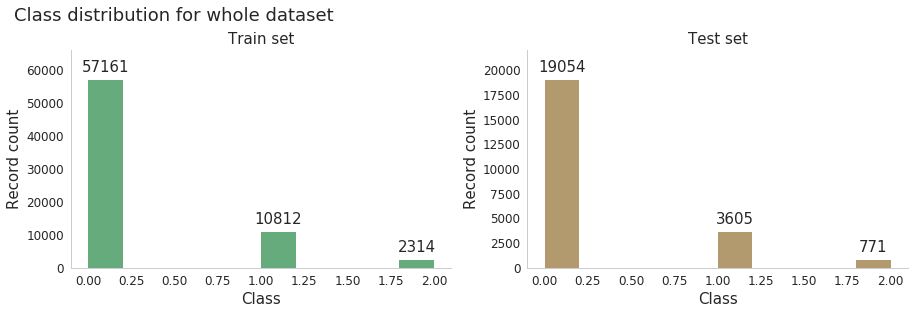

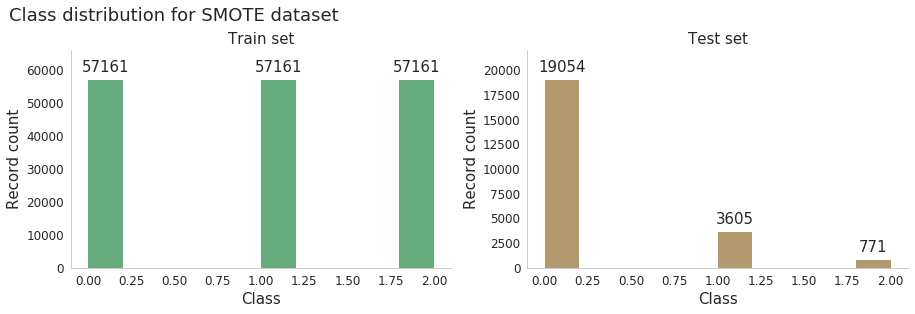

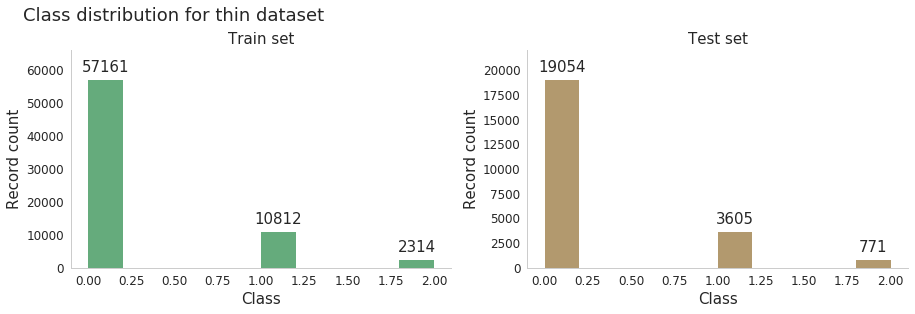

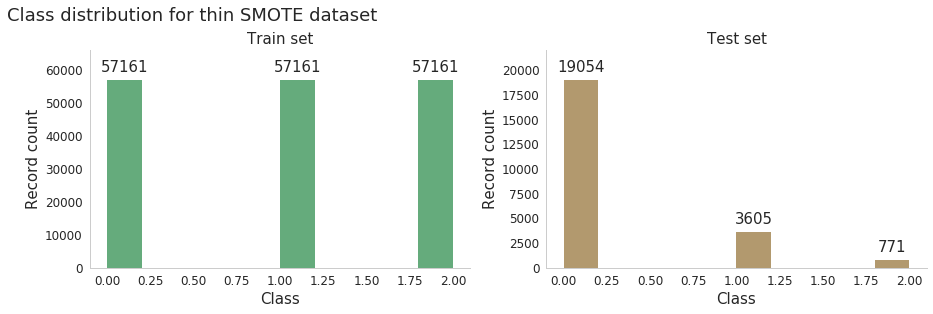

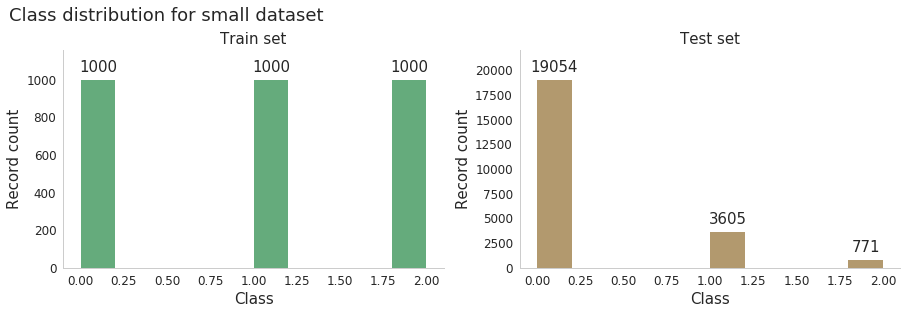

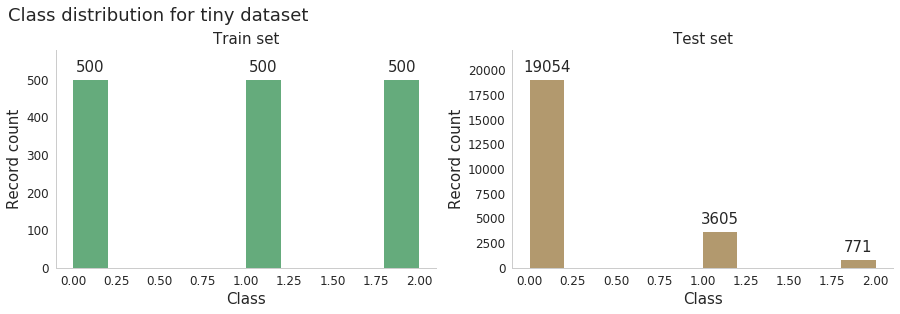

In [22]:
plot_class_hist(train_all_energiateollisuus, test_all_energiateollisuus, title='Class distribution for whole dataset', fontsize=15)
plot_class_hist(res_all_energiateollisuus, test_all_energiateollisuus, title='Class distribution for SMOTE dataset', fontsize=15)

plot_class_hist(train_thin_energiateollisuus, test_thin_energiateollisuus, title='Class distribution for thin dataset', fontsize=15)
plot_class_hist(res_thin_energiateollisuus, test_thin_energiateollisuus, title='Class distribution for thin SMOTE dataset', fontsize=15)

plot_class_hist(train_small_energiateollisuus, test_all_energiateollisuus, title='Class distribution for small dataset', fontsize=15)
plot_class_hist(train_tiny_energiateollisuus, test_all_energiateollisuus, title='Class distribution for tiny dataset', fontsize=15)

In [23]:
datasets = [('energiateollisuus_all_train', train_all_energiateollisuus), 
            ('energiateollisuus_all_test', test_all_energiateollisuus), 
            ('energiateollisuus_all_res', res_all_energiateollisuus),
            ('energiateollisuus_thin_train', train_thin_energiateollisuus),
            ('energiateollisuus_thin_test', test_thin_energiateollisuus),
            ('energiateollisuus_thin_res', res_thin_energiateollisuus),
            ('energiateollisuus_small_train', train_small_energiateollisuus),
            ('energiateollisuus_small_thin_train', train_thin_small_energiateollisuus),
            ('energiateollisuus_tiny_train', train_tiny_energiateollisuus),
            ('energiateollisuus_tiny_thin_train', train_thin_tiny_energiateollisuus),
           ]
save_dataset(datasets)